# Parameterizing MD correlation functions

In [1]:
# Make sure pyDR is installed and on the path
import sys
import os
if 'google.colab' in sys.modules: #Colab
    !git clone https://github.com/alsinmr/pyDR
else:
    os.chdir('../../..')

In [63]:
import pyDR
from pyDR.Fitting.fit import model_free
from pyDR.MDtools import vft
from pyDR.misc.tools import linear_ex
import numpy as np
import matplotlib.pyplot as plt
import MDAnalysis as mda
from time import time

In [3]:
# Download the trajectory files
xtc='https://drive.google.com/file/d/1wq5T-YDmPo2zAIWu9we2zyL2i-v52fnD/view?usp=sharing'
pdb='https://drive.google.com/file/d/1aBMUO2C1AZfx05dANl4QITHuqmHbDDsN/view?usp=sharing'

if not(os.path.exists('ubi.pdb')):
    pyDR.IO.download(pdb,'ubi.pdb')
if not(os.path.exists('ubi.xtc')):
    pyDR.IO.download(xtc,'ubi.xtc')

In [4]:
def align(uni,fileout='ubi_aligned.xtc',ref_sel='name CA'):
    """
    This function takes a trajectory and aligns it based on
    a reference selection of atoms. The new trajectory is
    returned in fileout (default is ubi_aligned.xtc)
    """
    
    from scipy.linalg import svd
    
    uni.trajectory[0] #Go to the first frame of the trajectory
    atoms=uni.atoms   #All atoms in the trajectory
    ref_sel=uni.select_atoms(ref_sel)  #Atom group for the reference
    
    ref0=ref_sel.positions #initial positions of reference atoms
    ref0-=ref0.mean(0) #Centers the initial position
    
    with mda.Writer(fileout,atoms.n_atoms) as W:
        for ts in uni.trajectory:
            ref=ref_sel.positions
            pos=atoms.positions

            pos-=ref.mean(0)   #This centers the reference
            ref-=ref.mean(0)   
            
            H=ref0.T@ref       #3x3 matrix
            U,S,Vt=svd(H)      #Singular value decomposition
            V=Vt.T             #Transposes
            Ut=U.T

            R=V@Ut             #Rotation matrix for alignment
            
            pos_corr=(R.T@pos.T).T
            atoms.positions=pos_corr
            
            W.write(atoms)
    return

In [6]:
uni0=mda.Universe('ubi.pdb','ubi.xtc')
if not(os.path.exists('ubi_aligned.xtc')):
    align(uni0,fileout='ubi_aligned.xtc')   #Runs the code to align Ubiquitin in the universe
uni=mda.Universe('ubi.pdb','ubi_aligned.xtc')  #Loads the aligned trajectory

In [51]:
proj=pyDR.Project()
proj.append_data('https://raw.githubusercontent.com/alsinmr/pyDR_tutorial/main/data/ubi_soln.txt')

sel=pyDR.MolSelect(topo='ubi.pdb',traj_files='ubi_aligned.xtc',project=proj)
sel.select_bond('15N')
pyDR.md2data(sel)


Loading Ref. Frames: |██████████████████████████████████████████████████| 100.0% Complete
Completed
r:MD:ubi_aligned with 72 data points


In [56]:
proj['MD']['raw'].detect.r_no_opt(12)
proj['MD']['raw'].fit()

Fitted 1 data objects
pyDIFRATE project with 1 data sets

Titles:
n12:MD:ubi_aligned


In [89]:
class MFfit():
        def __init__(self,z,A,error,fit,npars):
            self.npars=npars
            self.z=np.array(z)
            self.A=np.array(A)
            self.error=error
            self.fit=fit
        
        @property
        def S2(self):
            return 1-np.array([A0 for A0 in self.A]).sum(0)
        
        @property
        def tc(self):
            return 10**self.z
        
        def calc_rates(self,sens):
            out=[linear_ex(sens.z,sens.rhoz,z0)*A0 for z0,A0 in zip(self.z,self.A)]
            out=np.array(out).sum(0)
            if hasattr(sens,'R0'):
                out=(out.T+sens.R0).T
            return out
        
        def compare_rates(self,data):
            data.plot(style='bar')
            rates=self.calc_rates(data.sens)
            for R,a in zip(rates,data.project.plot_obj.ax):
                a.scatter(self.fit.label,R,color='black',s=10)
                
            return data.project.plot_obj
            

def MF(npars):
    if len(proj[f'p{npars}:MD:ubi_aligned'])==0:
        data=proj['MD']['no_opt'][0]
        data.detect.r_auto(npars)
        fit=data.fit()
    else:
        fit=proj[f'p{npars}:MD:ubi_aligned'][0]   
    nz=np.ceil(npars/2).astype(int)
    fixz=[-14.,*[None for _ in range(nz-1)]] if np.mod(npars,2) else None
    print(fixz)
    z,A,error,fit=model_free(fit,nz=nz,fixz=fixz)
    return MFfit(z,A,error,fit,npars)
    
def Detectors(npars):
    if len(proj[f'p{npars}:MD:ubi_aligned'])==0:
        data=proj['MD']['no_opt'][0]
        data.detect.r_auto(npars)
        fit=data.fit()
        

In [79]:
proj[0].label

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 20., 22., 23., 25., 26., 27., 29., 30., 32.,
       33., 34., 35., 36., 39., 40., 41., 42., 43., 44., 45., 46., 47.,
       48., 49., 50., 51., 52., 54., 55., 56., 57., 59., 60., 61., 62.,
       63., 64., 65., 66., 67., 68., 70., 71., 74., 75., 76.],
      dtype=float32)

In [91]:
mf=MF(4)

None
1 of 4 iterations
2 of 4 iterations


/Users/albertsmith/Documents/GitHub.nosync/pyDR/Fitting/fit.py:398: RuntimeWarning: invalid value encountered in reciprocal
  pinv=((m**2).sum(1)**(-1))*m.T


3 of 4 iterations
4 of 4 iterations
Data already in project (index=4)


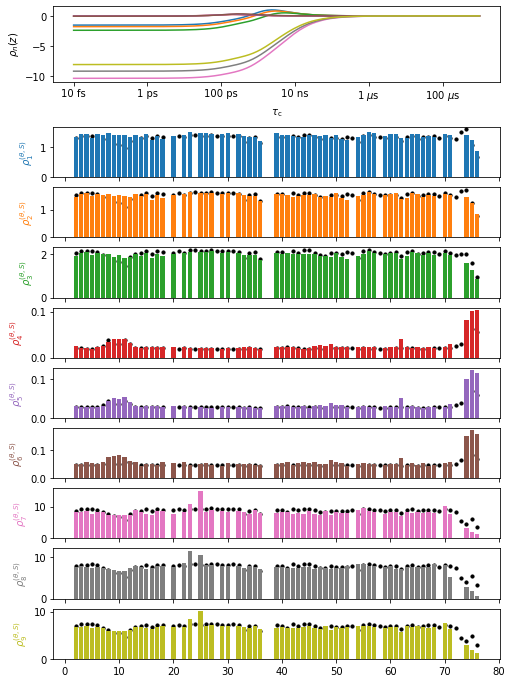

In [92]:
proj.close_fig('all')
mf.compare_rates(proj[0])
proj.fig.set_size_inches([8,12])

In [72]:
proj.current=1

In [74]:
proj.plot_obj.fig

AttributeError: 'NoneType' object has no attribute 'fig'